<b>Core architectural blueprint for a from-scratch agent loop in pure Python </b>

In [5]:
from IPython.display import Image

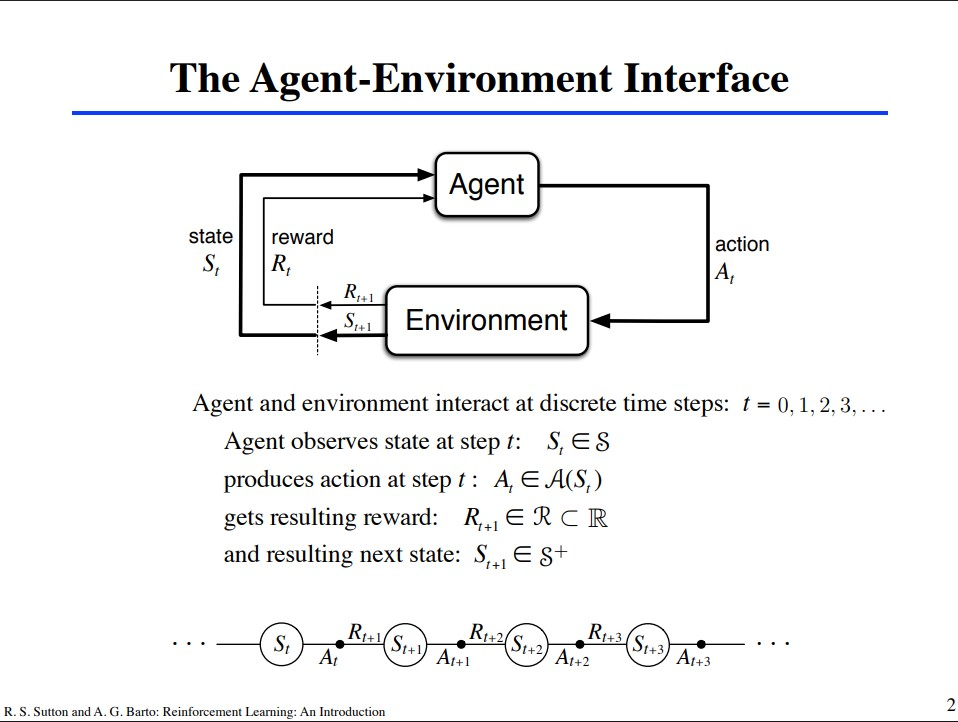

In [8]:
Image("agent_env_intface.jpg")

Mathematically, the loop is executing a continuous state transition: <br>
$S_{t+1} = \mathcal{T}(S_t, A_t)$. <br> $S_t$ (State): Your list of conversation messages (the context window).<br>
$A_t$ (Action): The LLM deciding to output text or call a Python function.<br>
$\mathcal{T}$ (Transition/Environment): Your Python code executing the tool and appending the result back to the state.<br>

1. <i>The State & The Action Space (Tools)</i>
First, we define the memory (state) and the functions the agent is allowed to execute (action space). We use a TOOL_REGISTRY to map string names returned by the LLM to actual Python memory addresses.

In [2]:
# 1. State Management (The Context Window)
# This is the agent's "short-term memory". We pass this entire list to the LLM every loop.
state_memory = [
    {"role": "system", "content": "You are a data agent. Use your tools to answer questions."}
]

# 2. The Action Space (Tools)
def query_database(sql_query: str) -> str:
    """Simulates executing a query against a database."""
    print(f"[SYSTEM] Executing DB Query: {sql_query}")
    # Imagine actual DB execution here
    return '{"users_found": 42}'

# The Registry: Maps LLM string outputs to real Python functions
TOOL_REGISTRY = {
    "query_database": query_database
}

2. <i>The Reasoning Engine (The LLM Wrapper) </i>
To keep this vendor-agnostic (OpenAI, Gemini, Anthropic), we wrap the API call in a function. The LLM acts as the policy engine: it looks at state_memory and decides whether to return a final string, or request a tool call.

In [3]:
def call_llm(messages: list) -> dict:
    """
    Simulates a call to an LLM API. 
    In production, this would use the official SDKs to return structured JSON.
    """
    # ... standard API call logic here ...
    
    # Example simulated response where the LLM decides to use a tool:
    return {
        "status": "tool_call",
        "tool_name": "query_database",
        "tool_args": {"sql_query": "SELECT COUNT(*) FROM users;"}
    }

3. The Core Agentic Loop
This is the heart of the system. It is a standard while True loop that persists until the LLM decides the task is complete.

In [4]:
def run_agent(user_request: str):
    # Append the initial user observation to the state
    state_memory.append({"role": "user", "content": user_request})
    
    step_count = 0
    max_steps = 5 # Guardrail against infinite loops
    
    while step_count < max_steps:
        step_count += 1
        print(f"\n--- Reasoning Step {step_count} ---")
        
        # 1. Policy Execution (LLM decides what to do based on current state)
        llm_response = call_llm(state_memory)
        
        # 2. Terminal State (LLM has the final answer)
        if llm_response["status"] == "complete":
            final_answer = llm_response["content"]
            state_memory.append({"role": "assistant", "content": final_answer})
            return final_answer
            
        # 3. Action Execution (LLM wants to use a tool)
        elif llm_response["status"] == "tool_call":
            tool_name = llm_response["tool_name"]
            tool_args = llm_response["tool_args"]
            
            # Fetch the actual python function from our registry
            target_function = TOOL_REGISTRY.get(tool_name)
            
            if not target_function:
                tool_result = f"Error: Tool '{tool_name}' does not exist."
            else:
                # Execute the code
                tool_result = target_function(**tool_args)
            
            # 4. State Update (Append the action AND the observation to memory)
            # The LLM must know *what* it asked for, and *what* the system returned.
            state_memory.append({
                "role": "assistant", 
                "content": f"Action taken: {tool_name} with args {tool_args}"
            })
            state_memory.append({
                "role": "system", 
                "content": f"Tool Result: {tool_result}"
            })
            
            # The loop continues, feeding this newly updated state back to the LLM.

    return "Error: Agent reached maximum steps without completing the task."

<b>Things to note</b>:

<i>Context Window Inflation</i>: Every pass through the loop appends at least two new dictionaries to state_memory. This is why tokens get expensive and models "forget" early instructions. You now know exactly where to insert context-pruning logic.

<i>Determinism</i>: The LLM does not execute code; it merely outputs strings (tool_name). You control the actual execution.

<i>Graph Equivalence</i>: This simple while loop is just a linear state machine. Frameworks like LangGraph simply allow you to route this logic across different nodes (e.g., passing the state to an "Evaluator LLM" before passing it to a "Coder LLM") instead of looping on a single node.

The biggest point of failure in this raw loop is <i>non-deterministic typing </i>: what happens when the LLM hallucinates an argument type (e.g., passing a string when your Python tool expects an integer)?